In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Heirarchy --- seasonality when sku level signal weak

In [13]:
df_raw = pd.read_excel("Hackathon Data.xlsx")

## Fill rate validation for important columns

In [15]:
df_raw["Encoded_SKU_ID"].nunique()

575

In [16]:
df_raw.head()

Encoded_SKU_ID SALES_DATE      SUBCLASS_NAME           CLASS_NAME  \
0               1 2017-09-28  MISC CAMERA ACCES  DIGITAL CAMERA ACCY   
1               2 2017-11-24   CAMERA BATTERIES  DIGITAL CAMERA ACCY   
2               3 2019-11-28           SO PARTS   MOBILE ACCESSORIES   
3               4 2021-04-21  SO RANGEHOODS REG  KITCHEN VENTILATION   
4               1 2018-10-27  MISC CAMERA ACCES  DIGITAL CAMERA ACCY   

               ML_NAME          CATEGORY_NAME  RETAIL_PRICE PROMO_PRICE  \
0  ML - DI Accessories   VP - Digital Imaging         89.99           ?   
1  ML - DI Accessories   VP - Digital Imaging         39.99           ?   
2   ML - Connected Car   VP - Electrify & Car         49.99           ?   
3         ML - Kitchen  VP - Major Appliances        549.99           ?   
4  ML - DI Accessories   VP - Digital Imaging         89.99           ?   

  COMPETITOR_PRICE      Inventory  DAILY_UNITS  
0                ?  Fully-Stocked            1  
1                ?  Fully-Stocked           18  
2            46.98    Constrained            7  
3              498  Fully-Stocked            6  
4                ?  Fully-Stocked            7

In [18]:
df_raw["Inventory"].unique()

array(['Fully-Stocked', 'Constrained', 'Moderate', 'Out-of-Stock'],
      dtype=object)

In [19]:
df_raw['Encoded_SKU_ID'].isna().sum()

0

In [93]:
df_subset=df_raw[['Encoded_SKU_ID','SALES_DATE','Inventory','DAILY_UNITS']]

In [94]:
df_subset['Inventory'].isna().sum()

0

In [95]:
df_subset['DAILY_UNITS'].isna().sum()

0

In [96]:
df_subset['Inventory'].value_counts()

Fully-Stocked    692604
Moderate          54825
Constrained       52711
Out-of-Stock      46492
Name: Inventory, dtype: int64

## Features Creation

In [97]:
df_subset["sales_yr"]=df_subset["SALES_DATE"].dt.year
df_subset["sales_quarter"]=df_subset["SALES_DATE"].dt.quarter

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/4032244470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["sales_yr"]=df_subset["SALES_DATE"].dt.year
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/4032244470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["sales_quarter"]=df_subset["SALES_DATE"].dt.quarter


In [98]:
def quarter(row):
    return 'Q'+ str(row.sales_quarter)+'_'+str(row.sales_yr)

In [99]:
df_subset.loc[:,'quarter']=df_subset.apply(lambda x:quarter(x), axis=1)

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/645980920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'quarter']=df_subset.apply(lambda x:quarter(x), axis=1)


In [35]:
df_subset.head()

Encoded_SKU_ID SALES_DATE      Inventory  DAILY_UNITS  sales_yr  \
0               1 2017-09-28  Fully-Stocked            1      2017   
1               2 2017-11-24  Fully-Stocked           18      2017   
2               3 2019-11-28    Constrained            7      2019   
3               4 2021-04-21  Fully-Stocked            6      2021   
4               1 2018-10-27  Fully-Stocked            7      2018   

   sales_quarter  quarter  
0              3  Q3_2017  
1              4  Q4_2017  
2              4  Q4_2019  
3              2  Q2_2021  
4              4  Q4_2018

In [36]:
df_subset.columns

Index(['Encoded_SKU_ID', 'SALES_DATE', 'Inventory', 'DAILY_UNITS', 'sales_yr',
       'sales_quarter', 'quarter'],
      dtype='object')

In [100]:
df_g1=df_subset.groupby(["Encoded_SKU_ID","quarter"],as_index=False).\
agg(avg_quarterly_units_sold=('DAILY_UNITS','mean'),std_quarterly_units_sold=('DAILY_UNITS',lambda x: x.std(ddof=0)))

In [102]:
df_g1.columns

Index(['Encoded_SKU_ID', 'quarter', 'avg_quarterly_units_sold',
       'std_quarterly_units_sold'],
      dtype='object')

In [103]:
df_m1=df_subset.merge(df_g1,on=['Encoded_SKU_ID','quarter'],how="inner")

In [104]:
df_m1

Encoded_SKU_ID SALES_DATE      Inventory  DAILY_UNITS  sales_yr  \
0                    1 2017-09-28  Fully-Stocked            1      2017   
1                    1 2017-08-27  Fully-Stocked            2      2017   
2                    1 2017-07-21  Fully-Stocked            6      2017   
3                    1 2017-07-14   Out-of-Stock            6      2017   
4                    1 2017-07-05   Out-of-Stock            2      2017   
...                ...        ...            ...          ...       ...   
846627             163 2019-09-29   Out-of-Stock            0      2019   
846628             563 2019-03-31   Out-of-Stock            0      2019   
846629             157 2017-12-28    Constrained           32      2017   
846630             157 2017-12-30    Constrained            9      2017   
846631             331 2019-06-30   Out-of-Stock            0      2019   

        sales_quarter  quarter  avg_quarterly_units_sold  \
0                   3  Q3_2017                  2.695652   
1                   3  Q3_2017                  2.695652   
2                   3  Q3_2017                  2.695652   
3                   3  Q3_2017                  2.695652   
4                   3  Q3_2017                  2.695652   
...               ...      ...                       ...   
846627              3  Q3_2019                  0.000000   
846628              1  Q1_2019                  0.000000   
846629              4  Q4_2017                 20.500000   
846630              4  Q4_2017                 20.500000   
846631              2  Q2_2019                  0.000000   

        std_quarterly_units_sold  
0                        1.64673  
1                        1.64673  
2                        1.64673  
3                        1.64673  
4                        1.64673  
...                          ...  
846627                   0.00000  
846628                   0.00000  
846629                  11.50000  
846630                  11.50000  
846631                   0.00000  

[846632 rows x 9 columns]

In [105]:
def unusual_sales(row):
    if(row["avg_quarterly_units_sold"]-2*row["std_quarterly_units_sold"]<=row["DAILY_UNITS"]<=row["avg_quarterly_units_sold"]+2*row["std_quarterly_units_sold"]):
            return "Usual_sales"
    else:
        return "Unusual sales"

## Those sales are defined as unusuals which have daily units sold outside the 2 standard deviation around the mean daily units sold for each SKU

In [106]:
df_m1["sales_status"]=df_m1.apply(lambda x:unusual_sales(x),axis=1)

In [123]:
df_g2=df_m1.groupby(["Encoded_SKU_ID","sales_status"],as_index=False).agg(Total_sales_sku=('DAILY_UNITS','sum'))

In [143]:
df_g2.groupby(["Encoded_SKU_ID"],as_index=False)["Total_sales_sku"].transform(sum)["Total_sales_sku"]

0        4273
1        4273
2       23783
3       23783
4        4468
        ...  
1145     6645
1146    19190
1147    19190
1148     6517
1149     6517
Name: Total_sales_sku, Length: 1150, dtype: int64

In [148]:
df_g2['%']=((df_g2["Total_sales_sku"])*100.0)/df_g2.groupby(["Encoded_SKU_ID"],as_index=False)["Total_sales_sku"]\
.transform(sum)["Total_sales_sku"]

In [165]:
th_1=df_g2[(df_g2["sales_status"]=="Unusual sales")]['%'].describe().loc['25%']
th_2=df_g2[(df_g2["sales_status"]=="Unusual sales")]['%'].describe().loc['75%']

In [186]:
n1=df_g2[(df_g2['%'].gt(20)) & (df_g2['sales_status']=="Unusual sales")].shape[0]
d1=df_g2['Encoded_SKU_ID'].nunique()

In [195]:
print(f"{n1} out of {d1} i.e. {(n1/d1)*100:.2f}% of SKU's have more than 20% of the daily units sold as unusual as per sales data ")

56 out of 575 i.e. 9.74% of SKU's have more than 20% of the daily units sold as unusual as per sales data 


In [586]:
skus_unusual=list(df_g2[(df_g2['%'].gt(20)) & (df_g2['sales_status']=="Unusual sales")]["Encoded_SKU_ID"].unique())

### These are sku's that have more than 20% unusual daily units sold data (unusual : not within 2 std of average units sold)

In [258]:
df_subset['year-month']=df_subset.SALES_DATE.dt.strftime('%Y-%m')
df_subset['year-quarter']=df_subset.SALES_DATE.dt.strftime('%Y-%q')

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/888065119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year-month']=df_subset.SALES_DATE.dt.strftime('%Y-%m')
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/888065119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year-quarter']=df_subset.SALES_DATE.dt.strftime('%Y-%q')


## Plotting various plots for analysis

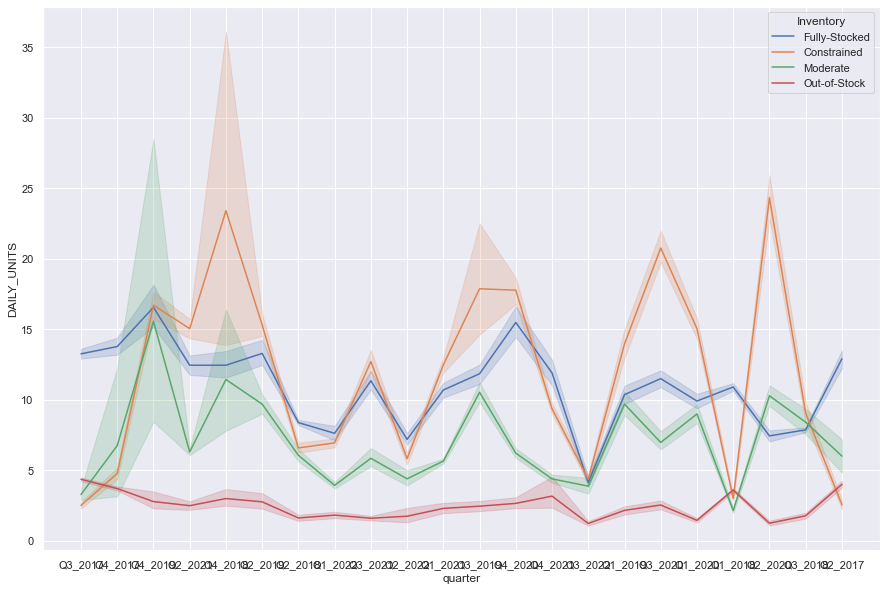

In [257]:
sns.set(rc={'figure.figsize':(15,10)})
g=sns.lineplot(data=df_subset,x="quarter",y="DAILY_UNITS",hue="Inventory")

## Observations : 

**Higher variance is seen in sales of products when they are in constrained or moderate state**<br>
**Moreover, when the inventory is full stock or out-of-stock state , then variance observed is low**

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/3200808804.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=list(sorted(df_subset['year-month'].unique())),rotation=90)


[Text(0, 0, '2017-05'),
 Text(1, 0, '2017-06'),
 Text(2, 0, '2017-07'),
 Text(3, 0, '2017-08'),
 Text(4, 0, '2017-09'),
 Text(5, 0, '2017-10'),
 Text(6, 0, '2017-11'),
 Text(7, 0, '2017-12'),
 Text(8, 0, '2018-01'),
 Text(9, 0, '2018-02'),
 Text(10, 0, '2018-03'),
 Text(11, 0, '2018-04'),
 Text(12, 0, '2018-05'),
 Text(13, 0, '2018-06'),
 Text(14, 0, '2018-07'),
 Text(15, 0, '2018-08'),
 Text(16, 0, '2018-09'),
 Text(17, 0, '2018-10'),
 Text(18, 0, '2018-11'),
 Text(19, 0, '2018-12'),
 Text(20, 0, '2019-01'),
 Text(21, 0, '2019-02'),
 Text(22, 0, '2019-03'),
 Text(23, 0, '2019-04'),
 Text(24, 0, '2019-05'),
 Text(25, 0, '2019-06'),
 Text(26, 0, '2019-07'),
 Text(27, 0, '2019-08'),
 Text(28, 0, '2019-09'),
 Text(29, 0, '2019-10'),
 Text(30, 0, '2019-11'),
 Text(31, 0, '2019-12'),
 Text(32, 0, '2020-01'),
 Text(33, 0, '2020-02'),
 Text(34, 0, '2020-03'),
 Text(35, 0, '2020-04'),
 Text(36, 0, '2020-05'),
 Text(37, 0, '2020-06'),
 Text(38, 0, '2020-07'),
 Text(39, 0, '2020-08'),
 Text(40, 

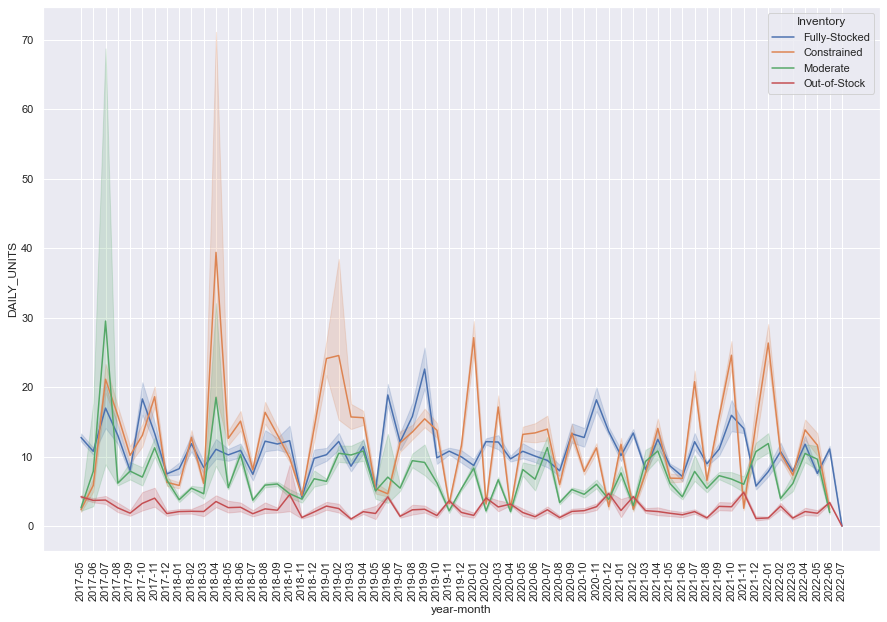

In [270]:
sns.set(rc={'figure.figsize':(15,10)})
g=sns.lineplot(data=df_subset,x="year-month",y="DAILY_UNITS",hue="Inventory")
g.set_xticklabels(labels=list(sorted(df_subset['year-month'].unique())),rotation=90)

In [219]:
df_g3=df_subset.groupby(["Encoded_SKU_ID","Inventory"],as_index=False).agg(n_dates=('SALES_DATE','count'),\
                                                                     avg_units_sold=('DAILY_UNITS','mean'),
                                                                    std_units_sold=('DAILY_UNITS',lambda x:x.std(ddof=0)))


In [272]:
df_g3['overall_sales']=df_g3.groupby('Encoded_SKU_ID')['n_dates'].transform(sum)

In [280]:
df_g3.head()

Encoded_SKU_ID      Inventory  n_dates  avg_units_sold  std_units_sold  \
0               1  Fully-Stocked     1828        2.271882        1.896079   
1               1   Out-of-Stock       56        2.142857        1.528638   
2               2  Fully-Stocked     1877       12.524241        9.061859   
3               2   Out-of-Stock       14       19.642857       14.787094   
4               3    Constrained      381        4.280840        2.737391   

   overall_sales  
0           1884  
1           1884  
2           1891  
3           1891  
4           1838

In [292]:
df_g3['%']=round((df_g3['n_dates']/df_g3['overall_sales'])*100,2)

In [294]:
df_g3.drop(columns='full_stock_%',inplace=True)

### Analysis of SKU's that are Fully stocked for more than 99% of the days

In [305]:
p1=df_g3[(df_g3['Inventory']=='Fully-Stocked') & (df_g3['%']>99.0)]['Encoded_SKU_ID'].nunique()/df_g3['Encoded_SKU_ID'].nunique()

In [306]:
print(f"{p1*100:.2f} % of SKUs are fully stocked for more than 99% of the days")

22.26 % of SKUs are fully stocked for more than 99% of the days


## Analysis of SKU's which are very slow moving based on 2 attributes : 

**Percentage of days unsold since the launch of the product**<br>
**Average consecutive shelf life**

In [402]:
df_pad=pd.read_csv("train_data_padded.csv")

In [403]:
df_pad.drop(columns="Unnamed: 0",inplace=True)

In [404]:
df_pad["DAILY_UNITS"]=df_pad["DAILY_UNITS"].astype(int)

In [405]:
df_pad["Daily_units_str"]=df_pad["DAILY_UNITS"].apply(lambda x:'y' if x!=0 else 'n')

In [406]:
df_pad.head()

date  Encoded_SKU_ID  DAILY_UNITS Daily_units_str
0  2017-05-28             1.0            0               n
1  2017-05-29             1.0            0               n
2  2017-05-30             1.0            0               n
3  2017-05-31             1.0            0               n
4  2017-06-01             1.0            0               n

In [407]:
df_g4=df_pad.groupby(["Encoded_SKU_ID"],as_index=False)["Daily_units_str"].sum()

In [408]:
df_g5=df_pad.groupby(["Encoded_SKU_ID","Daily_units_str"],as_index=False).agg(total_days=("date","count"))

In [409]:
df_g5["total_days_overall"]=df_g5.groupby(["Encoded_SKU_ID"])["total_days"].transform(sum)

In [410]:
df_g5['%']=np.round((df_g5['total_days']/df_g5['total_days_overall'])*100,2)

In [411]:
df_g5[(df_g5["Daily_units_str"]=='n')]['%'].describe()

count    574.000000
mean      20.266916
std       16.963450
min        0.060000
25%        5.627500
50%       15.095000
75%       31.637500
max       73.230000
Name: %, dtype: float64

In [440]:
df_g5["rank"]=df_g5.groupby(["Daily_units_str"])['%'].transform(lambda x:x.rank(method='dense',ascending=False))

### Set of SKU's : These are the top 20 slowest moving sku's with more than 54 % of days unsold since launch

In [533]:
set_1=set(df_g5[(df_g5["Daily_units_str"]=="n") & (df_g5["rank"]<=20)].sort_values(by=["rank"])["Encoded_SKU_ID"].unique())

In [466]:
df_g5[(df_g5["Daily_units_str"]=="n") & (df_g5["%"]>=60)]

Encoded_SKU_ID Daily_units_str  total_days  total_days_overall      %  \
308            155.0               n        1269                1733  73.23   
352            177.0               n        1180                1877  62.87   
815            409.0               n         694                1104  62.86   
911            457.0               n         992                1599  62.04   
1031           517.0               n        1092                1583  68.98   

      rank  
308    1.0  
352    3.0  
815    4.0  
911    5.0  
1031   2.0

### 5 sku's are unsold on more than 60% of days
### Top 10 sku's based on number of unsold days

In [470]:
df_g5[(df_g5["Daily_units_str"]=="n") & (df_g5["rank"]<=10)]

Encoded_SKU_ID Daily_units_str  total_days  total_days_overall      %  \
190             96.0               n         932                1583  58.88   
308            155.0               n        1269                1733  73.23   
314            158.0               n        1108                1870  59.25   
330            166.0               n        1113                1891  58.86   
352            177.0               n        1180                1877  62.87   
493            248.0               n        1036                1751  59.17   
815            409.0               n         694                1104  62.86   
853            428.0               n         945                1583  59.70   
911            457.0               n         992                1599  62.04   
1031           517.0               n        1092                1583  68.98   

      rank  
190    9.0  
308    1.0  
314    7.0  
330   10.0  
352    3.0  
493    8.0  
815    4.0  
853    6.0  
911    5.0  
1031   2.0

In [490]:
df_g6=df_pad.groupby(["Encoded_SKU_ID"],as_index=False)["Daily_units_str"].sum()

In [510]:
df_g6.head()

Encoded_SKU_ID                                    Daily_units_str
0             1.0  nnnnnyyyyyyyyyyyyyynynyyyyyyyyyynyyyyyyyyyyyyy...
1             2.0  nnnnnyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...
2             3.0  nnnyyyynynnnnynynynnyynnyyynnyyyynnnynnnyynyny...
3             4.0  yyyyyyyyyyyyyyyyyyyyyyyyynyyyyyyyyyyyyynyyyyyy...
4             5.0  nnnnnyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...

In [514]:
df_g6.loc[:,"avg_shelf_life"]=df_g6["Daily_units_str"].apply(lambda x:np.mean([len(i) for i in x.split('y') if i!='']))  

In [517]:
df_g6["rank"]=df_g6["avg_shelf_life"].rank(method='dense',ascending=False)

### These are the SKU's which have the highest shelf life and the top 5 have it more than 15 days on average i.e. they remain unsold for >15 consecutive days on average

In [532]:
set_2=set(df_g6[df_g6["rank"].between(1,20)].sort_values(by=["rank"])["Encoded_SKU_ID"].unique())

In [538]:
list(df_g6[df_g6["rank"].between(1,20)].sort_values(by=["rank"])["Encoded_SKU_ID"].unique())

[424.0,
 207.0,
 101.0,
 387.0,
 252.0,
 449.0,
 201.0,
 494.0,
 37.0,
 304.0,
 452.0,
 4.0,
 69.0,
 378.0,
 358.0,
 526.0,
 223.0,
 157.0,
 446.0,
 409.0]

### Binning the average shelf life column into 5tile

In [547]:
df_g6["5tile"]=pd.qcut(df_g6["avg_shelf_life"],5,labels=[1,2,3,4,5])

In [572]:
slow_skus=list(df_g6[df_g6["rank"].between(1,20)]["Encoded_SKU_ID"])

## Defining outlier as those set of 20 SKUs which have highest average shelf life i.e. slowest moving

In [577]:
df_g6["Outlier_status"]=df_g6["Encoded_SKU_ID"].apply(lambda x:"outlier" if x in slow_skus else "not outlier")

In [578]:
df_g6

Encoded_SKU_ID                                    Daily_units_str  \
0               1.0  nnnnnyyyyyyyyyyyyyynynyyyyyyyyyynyyyyyyyyyyyyy...   
1               2.0  nnnnnyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...   
2               3.0  nnnyyyynynnnnynynynnyynnyyynnyyyynnnynnnyynyny...   
3               4.0  yyyyyyyyyyyyyyyyyyyyyyyyynyyyyyyyyyyyyynyyyyyy...   
4               5.0  nnnnnyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...   
..              ...                                                ...   
570           571.0  ynnynnnynynnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...   
571           572.0  nnnyynyyyyynyyyynnnyynyyyyyynyyyyyyyynyyynynyy...   
572           573.0  nnnnnynynyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...   
573           574.0  nnnyyyynnyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...   
574           575.0  nnnnnnyyynnnynnnnyyyynynnnnynynnnynynnyynnnyny...   

     avg_shelf_life   rank 5tile Outlier_status  
0          1.416327  373.0     2    not outlier  
1          1.147059  497.0     1    not outlier  
2          1.845833  224.0     3    not outlier  
3          9.387755   12.0     5        outlier  
4          1.113924  510.0     1    not outlier  
..              ...    ...   ...            ...  
570        3.224490   63.0     5    not outlier  
571        1.147059  497.0     1    not outlier  
572        1.656250  286.0     3    not outlier  
573        2.071429  188.0     4    not outlier  
574        2.073529  187.0     4    not outlier  

[575 rows x 6 columns]

In [556]:
pd.qcut(df_g6["avg_shelf_life"],5).unique()

[(1.288, 1.524], (0.999, 1.288], (1.524, 1.867], (2.576, 399.0], (1.867, 2.576], NaN]
Categories (5, interval[float64, right]): [(0.999, 1.288] < (1.288, 1.524] < (1.524, 1.867] < (1.867, 2.576] < (2.576, 399.0]]

In [551]:
df_g6["5tile"].value_counts()

2    116
1    115
4    115
5    115
3    113
Name: 5tile, dtype: int64

In [564]:
df_s2

Encoded_SKU_ID SALES_DATE      Inventory  DAILY_UNITS  sales_yr  \
0                    1 2017-09-28  Fully-Stocked            1      2017   
1                    1 2018-10-27  Fully-Stocked            7      2018   
2                    1 2017-08-27  Fully-Stocked            2      2017   
3                    1 2021-03-08  Fully-Stocked            0      2021   
4                    1 2019-11-04  Fully-Stocked            5      2019   
...                ...        ...            ...          ...       ...   
846627             557 2021-10-02  Fully-Stocked          234      2021   
846628             557 2020-11-02  Fully-Stocked           73      2020   
846629             557 2020-09-25  Fully-Stocked           67      2020   
846630             557 2022-05-13  Fully-Stocked          215      2022   
846631             557 2021-12-27  Fully-Stocked          360      2021   

        sales_quarter  quarter year-month year-quarter  avg_shelf_life 5tile  
0                   3  Q3_2017    2017-09       2017-q        1.416327     2  
1                   4  Q4_2018    2018-10       2018-q        1.416327     2  
2                   3  Q3_2017    2017-08       2017-q        1.416327     2  
3                   1  Q1_2021    2021-03       2021-q        1.416327     2  
4                   4  Q4_2019    2019-11       2019-q        1.416327     2  
...               ...      ...        ...          ...             ...   ...  
846627              4  Q4_2021    2021-10       2021-q        1.000000     1  
846628              4  Q4_2020    2020-11       2020-q        1.000000     1  
846629              3  Q3_2020    2020-09       2020-q        1.000000     1  
846630              2  Q2_2022    2022-05       2022-q        1.000000     1  
846631              4  Q4_2021    2021-12       2021-q        1.000000     1  

[846632 rows x 11 columns]

In [579]:
df_s2=df_subset.merge(df_g6[["Encoded_SKU_ID","avg_shelf_life","5tile","Outlier_status"]],on="Encoded_SKU_ID",how="inner")

In [566]:
df_g8=df_s2.groupby(["5tile","sales_yr"],as_index=False)["DAILY_UNITS"].mean()

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/1484062909.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels=list(sorted(df_subset['sales_yr'].unique())),rotation=45)


[Text(2016.0, 0, '2017'),
 Text(2017.0, 0, '2018'),
 Text(2018.0, 0, '2019'),
 Text(2019.0, 0, '2020'),
 Text(2020.0, 0, '2021'),
 Text(2021.0, 0, '2022'),
 Text(2022.0, 0, ''),
 Text(2023.0, 0, '')]

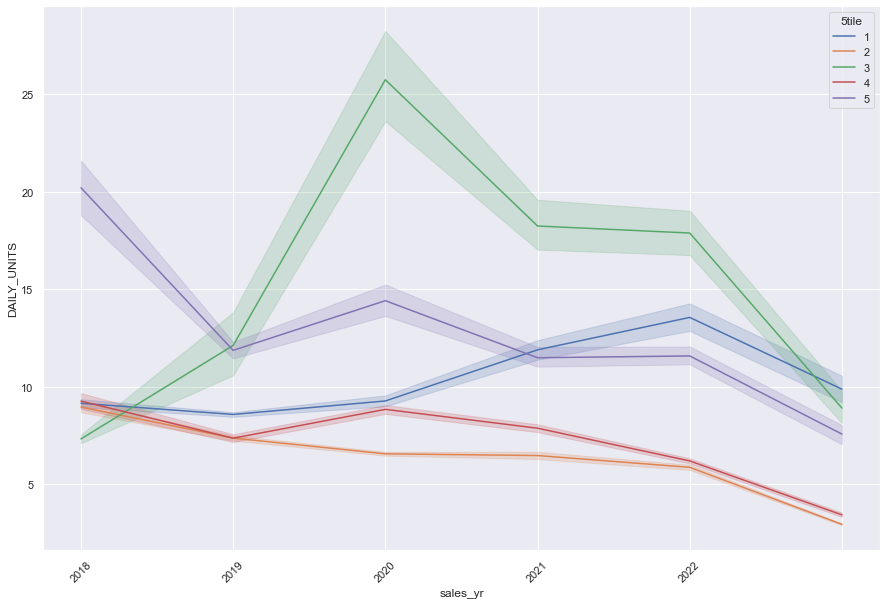

In [568]:
sns.set(rc={'figure.figsize':(15,10)})
g1=sns.lineplot(data=df_s2,x="sales_yr",y="DAILY_UNITS",hue="5tile")
g1.set_xticklabels(labels=list(sorted(df_subset['sales_yr'].unique())),rotation=45)

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_67142/93247624.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels=list(sorted(df_subset['sales_yr'].unique())),rotation=45)


[Text(2016.0, 0, '2017'),
 Text(2017.0, 0, '2018'),
 Text(2018.0, 0, '2019'),
 Text(2019.0, 0, '2020'),
 Text(2020.0, 0, '2021'),
 Text(2021.0, 0, '2022'),
 Text(2022.0, 0, ''),
 Text(2023.0, 0, '')]

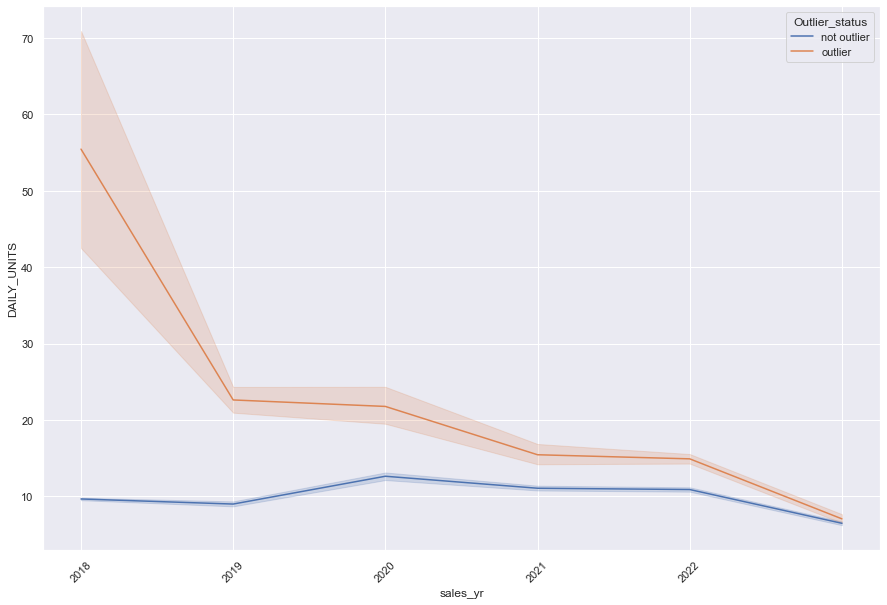

In [583]:
sns.set(rc={'figure.figsize':(15,10)})
g1=sns.lineplot(data=df_s2,x="sales_yr",y="DAILY_UNITS",hue="Outlier_status")
g1.set_xticklabels(labels=list(sorted(df_subset['sales_yr'].unique())),rotation=45)

### Conclusion : The above graph clearly shows that the outlier SKUs i.e. those 20 SKUs which have highest average shelf life (slowest moving SKUs) have very high volatility/variability as compared to other SKUs